## Import the dependencies

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime 
import yfinance as yf
import pandas_datareader as pdr
import optuna

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from xgboost import XGBRegressor
from xgboost import plot_importance

import warnings
warnings.filterwarnings("ignore")
plt.style.use('ggplot')

## Data Loading and Pre-preocessing

In [6]:
data_stock = yf.download('NVDA')

[*********************100%%**********************]  1 of 1 completed


In [9]:
days_to_pred = 15

years = int(len(data_stock) - 365*15)
data_stock = data_stock.iloc[years:]

len(data_stock)/365

15.0

In [10]:
data_stock.drop(columns=['Open', 'High', 'Low', 'Adj Close', 'Volume'],inplace=True)

In [11]:
def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [13]:
def add_lags(df,num_days_pred=days_to_pred):
    target = 'Close'
    df['lag1'] = df[target].shift(num_days_pred)  
    df['lag2'] = df[target].shift(num_days_pred*2)    
    df['lag3'] = df[target].shift(num_days_pred*3)    
    df['lag4'] = df[target].shift(num_days_pred*4)    
    df['lag5'] = df[target].shift(num_days_pred*5)
    df['lag6'] = df[target].shift(num_days_pred*6)
    df['lag7'] = df[target].shift(num_days_pred*7)
    df['lag8'] = df[target].shift(num_days_pred*8)
    df['lag9'] = df[target].shift(num_days_pred*9)
    df['lag10'] = df[target].shift(num_days_pred*10)
    df['lag11'] = df[target].shift(num_days_pred*11)
    df['lag12'] = df[target].shift(num_days_pred*12)
    df['lag13'] = df[target].shift(num_days_pred*13)
    df['lag14'] = df[target].shift(num_days_pred*14)
    df['lag15'] = df[target].shift(num_days_pred*15)

    return df

In [14]:
def add_features(df):
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

## ARIMA Forecast

In [16]:
df_arima = data_stock.copy()

split_date = df_arima.index[int(len(df_arima) * 0.8)]
train_arima = df_arima.loc[df_arima.index <= split_date].copy()
test_arima = df_arima.loc[df_arima.index > split_date].copy()

In [17]:
# Find Best parameters
stepwise_fit = auto_arima(train_arima['Close'],trace=True,suppress_warnings=True)

# Assign to Best Order Variable
best_order = stepwise_fit.get_params()['order']

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-11447.756, Time=2.01 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-11318.360, Time=0.25 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-11391.309, Time=0.33 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-11378.096, Time=0.40 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-11318.160, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-11445.307, Time=1.00 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-11435.861, Time=2.02 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-11456.413, Time=3.65 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-11439.961, Time=0.38 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=-11444.740, Time=4.16 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=-11443.290, Time=4.19 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-11443.479, Time=3.23 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-11438.569, Time=0.97 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=-11462.760, Time=4.73 sec
 ARIM

In [18]:
# Train ARIMA

arima = ARIMA(train_arima['Close'], order=best_order)
arima = arima.fit()

# Evaluate 

start = len(train_arima)
end = len(test_arima) + len(train_arima)

<Axes: xlabel='Date'>

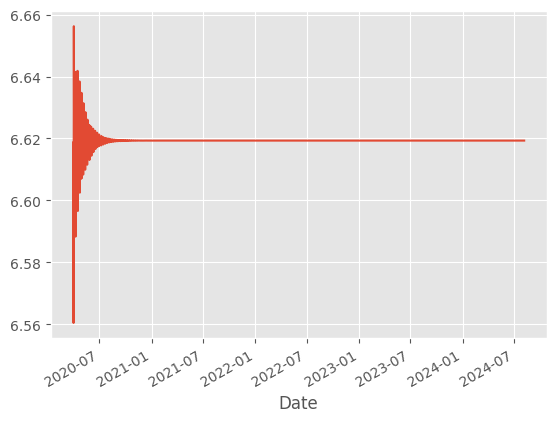

In [19]:
# Predict

pred_arima = arima.predict(start=start,end=end-1)
pred_arima.index = test_arima.index
pred_arima.plot()

In [21]:
# LOSS - MAPE

arima_loss = mape(test_arima['Close'],pred_arima )
print(f"ERROR PERCENT = { mape(test_arima['Close'],pred_arima ) }% ")

ERROR PERCENT = 66.0696084240769% 


In [22]:
# Predict future

stepwise_fit = auto_arima(df_arima['Close'],trace=True,suppress_warnings=True)
best_order = stepwise_fit.get_params()['order']

arima = ARIMA(df_arima['Close'], order=best_order)
arima = arima.fit()

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=inf, Time=1.47 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=15082.567, Time=0.07 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=13211.705, Time=0.10 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=inf, Time=0.42 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=12502.322, Time=0.17 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=11863.141, Time=0.30 sec
 ARIMA(4,2,0)(0,0,0)[0]             : AIC=11715.770, Time=0.32 sec
 ARIMA(5,2,0)(0,0,0)[0]             : AIC=11330.385, Time=0.42 sec
 ARIMA(5,2,1)(0,0,0)[0]             : AIC=10656.170, Time=1.01 sec
 ARIMA(4,2,1)(0,0,0)[0]             : AIC=10722.688, Time=0.82 sec
 ARIMA(5,2,2)(0,0,0)[0]             : AIC=10655.860, Time=1.75 sec
 ARIMA(4,2,2)(0,0,0)[0]             : AIC=10698.740, Time=1.19 sec
 ARIMA(5,2,3)(0,0,0)[0]             : AIC=10662.358, Time=3.94 sec
 ARIMA(4,2,3)(0,0,0)[0]             : AIC=inf, Time=3.22 sec
 ARIMA(5,2,2)(0,0,0)[0] intercept   :

In [24]:
start = len(df_arima)
end = len(df_arima) + days_to_pred
arima_forecast = arima.predict(start=start,end=end)

In [26]:
start = df_arima.index.max()
end = start + pd.Timedelta(days=days_to_pred)
arima_forecast.index = pd.date_range(start, end, freq='1d')

In [27]:
arima_forecast = pd.DataFrame(arima_forecast)
arima_forecast

,predicted_mean
2024-08-05,102.309297
2024-08-06,99.434292
2024-08-07,100.102495
2024-08-08,98.254161
2024-08-09,97.653276
2024-08-10,95.617293
2024-08-11,94.727430
2024-08-12,93.084845
2024-08-13,92.053800
2024-08-14,90.626391


## Explanaible AI

In [29]:
# Model - XG Boost

df_xgb = data_stock.copy()

In [34]:
def xgboostmodel(df_xgb,add_lags,create_features,num_days_pred=days_to_pred):

    df_xgb = create_features(df_xgb)
    df_xgb = add_lags(df_xgb)
    
    X = df_xgb.drop(columns='Close')
    y = df_xgb['Close']
    return X,y


X,y = xgboostmodel(df_xgb ,add_lags,add_features,num_days_pred=30)


In [49]:
# Objective Function
def objective(trial):
    # Hyperparameters
    param = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),
        'verbosity': 0,
    }
    
    xgb = XGBRegressor(**param)
    
    xgb.fit(X_train, y_train)
    
    y_pred = xgb.predict(X_test)

    # Error
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    return rmse

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

print("Best trial:")
best_trial = study.best_trial
print(f"  Value: {best_trial.value}")
print("  Params: ")
for key, value in best_trial.params.items():
    print(f"    {key}: {value}")

[I 2024-08-05 20:49:40,699] A new study created in memory with name: no-name-67dd02d3-425b-449c-a250-631e6a7ed33a
[I 2024-08-05 20:49:41,845] Trial 0 finished with value: 0.6920127066918705 and parameters: {'n_estimators': 960, 'max_depth': 6, 'learning_rate': 0.054572530532475585, 'subsample': 0.7755677619379228, 'colsample_bytree': 0.6874287706773538, 'reg_alpha': 6.959440087764631, 'reg_lambda': 5.537627710115782}. Best is trial 0 with value: 0.6920127066918705.
[I 2024-08-05 20:49:42,127] Trial 1 finished with value: 0.7280254194074288 and parameters: {'n_estimators': 138, 'max_depth': 7, 'learning_rate': 0.0521843153596505, 'subsample': 0.9303387932761957, 'colsample_bytree': 0.6997063436447168, 'reg_alpha': 2.3420351966326134, 'reg_lambda': 3.8452281604743357}. Best is trial 0 with value: 0.6920127066918705.
[I 2024-08-05 20:49:42,959] Trial 2 finished with value: 0.7090008587808014 and parameters: {'n_estimators': 761, 'max_depth': 5, 'learning_rate': 0.045694817398330305, 'subs

Best trial:
  Value: 0.6072854957491574
  Params: 
    n_estimators: 422
    max_depth: 8
    learning_rate: 0.04877304381444269
    subsample: 0.6674391917731362
    colsample_bytree: 0.8463560322157639
    reg_alpha: 0.5811427013426197
    reg_lambda: 0.06992290572856238


In [51]:
# Best params training
best_params = best_trial.params
xgb_best = XGBRegressor(**best_params)
xgb_best.fit(X_train, y_train)

# Predictions 
y_pred_test = xgb_best.predict(X_test)

# Calculate RMSE 
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
print("Test RMSE:", rmse_test)

Test RMSE: 0.6072854957491574


In [53]:
# Evaluate 

y_pred_test_xgb = xgb_best.predict(X_test)
xgb_loss = mape(y_test, y_pred_test_xgb) 
print(f"ERROR PERCENT = { mape(y_test, y_pred_test_xgb) }% ")

ERROR PERCENT = 4.850089239054457% 


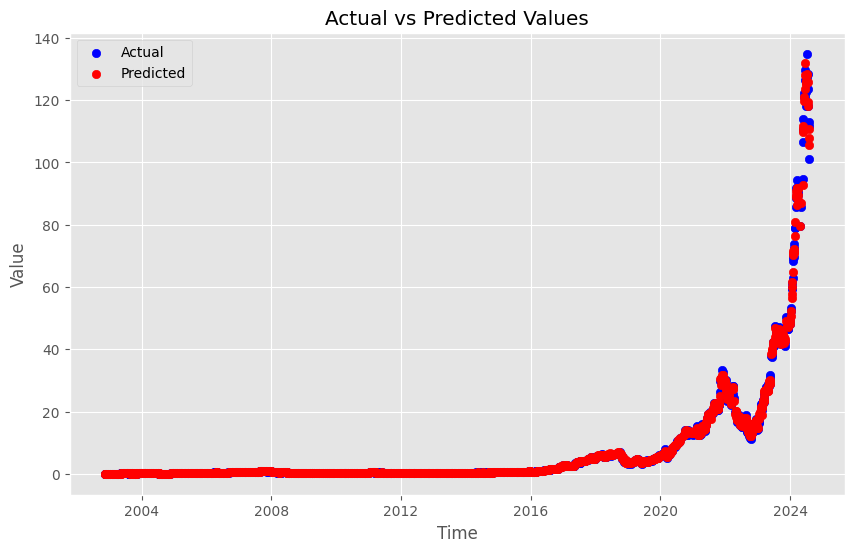

In [54]:
# Plot actual vs predict

plt.figure(figsize=(10, 6))
plt.scatter(X_test.index, y_test, color='blue', label='Actual')
plt.scatter(X_test.index, y_pred_test_xgb , color='red', label='Predicted')
plt.title('Actual vs Predicted Values')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

<Figure size 1000x600 with 0 Axes>

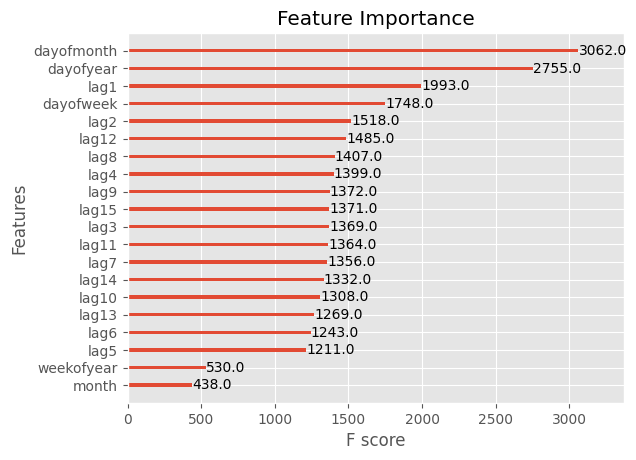

In [55]:
# Plot feature importance

plt.figure(figsize=(10, 6))
plot_importance(xgb_best, max_num_features=20)
plt.title("Feature Importance")
plt.show()